<center><img src="https://estakapital.co.id/assets/img/logo-dark1.png" width=30% title="ESTA Logo"></center>

### CREDIT SCORING ANALYSIS

##### One of the challenges that the company is facing is establishing a credible credit ranking system. The goals of this project is to improve the current credit ranking system by analyzing the collected data for greater resource use efficiency.

This project will not only explore:
1. Key Performance Metrics that influence a borrower's credit score (e.g. home ownership, marital status, loan amount, etc.)
2. Actual CS EKF vs. Predicted CS EKF
3. Aging trigger point that should be considered as "bad debt"

In [1]:
# Data processing
import pandas as pd
# Linear algebra
import numpy as np

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data splitting & parameter tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingClassifier

# Feature selection
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

# Evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score

# Further processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#### Data Exploration

In [2]:
# Import the dataset
data = pd.read_csv('BorrowerReport.csv')

# Show the first 2 lines to verify that we have imported the dataset correctly 
data.head(3)

,Draft Code Borrower,Borrower ID,Name,No Submission of Contract,Business Sector,Type of Business,State,Issue Date,Loan Amount,Interest [%],...,CS EDV,CS EKF,Projected Returns,Gender,DOB,Marital Status,Home Ownership,Length of Stay,Loan Purpose,Another Loan
0,D19008838,B1907000188,SILVANA BAKARI,027.0719.0013,PERDAGANGAN,DAGANG BENSIN,GORONTALO UTARA,03-07-19,"3,910,000",12,...,3,B,"318,213",P,30-04-83,KAWIN,MILIK SENDIRI,10,MENAMBAH MODAL USAHA,NO
1,D19008837,B1907000187,MARIANA WOGONO,054.0719.0044,PERDAGANGAN,JUALAN IKAN,HALMAHERA UTARA,03-07-19,"3,410,000",12,...,3,B,"355,426",P,25-09-78,KAWIN,MILIK SENDIRI,7,MENAMBAH MODAL USAHA,NO
2,D19008836,B1907000186,KINAH,029.0719.0003,PERDAGANGAN,WARUNG JAJANAN DAN PEMANCINGAN,KARAWANG,03-07-19,"4,910,000",12,...,3,B,"399,598",P,13-04-72,KAWIN,MILIK SENDIRI,8,MENAMBAH MODAL USAHA,YES


In [3]:
# Show the last 2 lines just to be sure!
data.tail(2)

,Draft Code Borrower,Borrower ID,Name,No Submission of Contract,Business Sector,Type of Business,State,Issue Date,Loan Amount,Interest [%],...,CS EDV,CS EKF,Projected Returns,Gender,DOB,Marital Status,Home Ownership,Length of Stay,Loan Purpose,Another Loan
16173,D18000002,B1802000002,UNUY MARTINI,012.0218.0024,INDUSTRI,KONPEKSI,BEKASI,06-02-18,"4,300,000",10,...,3,B,"284,461",P,18-02-71,KAWIN,NaN,NaN,NaN,NaN
16174,D18000001,B1802000001,IYOM,012.0218.0021,PERDAGANGAN,JUAL GORENGAN,BEKASI,06-02-18,"4,300,000",10,...,3,B,"284,461",P,04-01-75,KAWIN,NaN,NaN,NaN,NaN


In [4]:
# Checking the type of data in each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16175 entries, 0 to 16174
Data columns (total 23 columns):
Draft Code Borrower             16175 non-null object
Borrower ID                     16175 non-null object
Name                            16175 non-null object
No Submission of Contract       16175 non-null object
Business Sector                 16175 non-null object
Type of Business                16175 non-null object
State                           16175 non-null object
Issue Date                      16175 non-null object
Loan Amount                     16175 non-null object
Interest [%]                    16175 non-null int64
Maturity                        16175 non-null int64
Maturity Type                   16175 non-null object
Length of Business Ownership    15757 non-null object
CS EDV                          16175 non-null int64
CS EKF                          16175 non-null object
Projected Returns               16175 non-null object
Gender                        

In [5]:
# Dropping unrelevant features
data.drop(['Borrower ID', 'Draft Code Borrower', 'Name', 'No Submission of Contract', 'Type of Business', 
           'Issue Date', 'DOB', 'Projected Returns', 'CS EDV', 'Maturity Type'], axis=1, inplace=True)

In [6]:
# Convert the string number value to a float 
# Remove $, Remove Commas, Convert to a float type

def convert_currency(val):
    new_val = val.replace(',','').replace('$', '')
    return float(new_val)

data['Loan Amount'] = data['Loan Amount'].apply(convert_currency)

In [7]:
# Check the data type of Loan Amount has been converted
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16175 entries, 0 to 16174
Data columns (total 13 columns):
Business Sector                 16175 non-null object
State                           16175 non-null object
Loan Amount                     16175 non-null float64
Interest [%]                    16175 non-null int64
Maturity                        16175 non-null int64
Length of Business Ownership    15757 non-null object
CS EKF                          16175 non-null object
Gender                          16175 non-null object
Marital Status                  16175 non-null object
Home Ownership                  7393 non-null object
Length of Stay                  7393 non-null object
Loan Purpose                    7393 non-null object
Another Loan                    7393 non-null object
dtypes: float64(1), int64(2), object(10)
memory usage: 1.6+ MB


In [8]:
# Checking if there is a null value
data.isna().sum()

Business Sector                    0
State                              0
Loan Amount                        0
Interest [%]                       0
Maturity                           0
Length of Business Ownership     418
CS EKF                             0
Gender                             0
Marital Status                     0
Home Ownership                  8782
Length of Stay                  8782
Loan Purpose                    8782
Another Loan                    8782
dtype: int64

In [9]:
# Dropping the null values data
data = data.dropna()

In [10]:
# Determining number of rows and columns in the dataset
print('Number of rows in the dataset: ',data.shape[0])
print('Number of columns in the dataset: ',data.shape[1])

Number of rows in the dataset:  7377
Number of columns in the dataset:  13


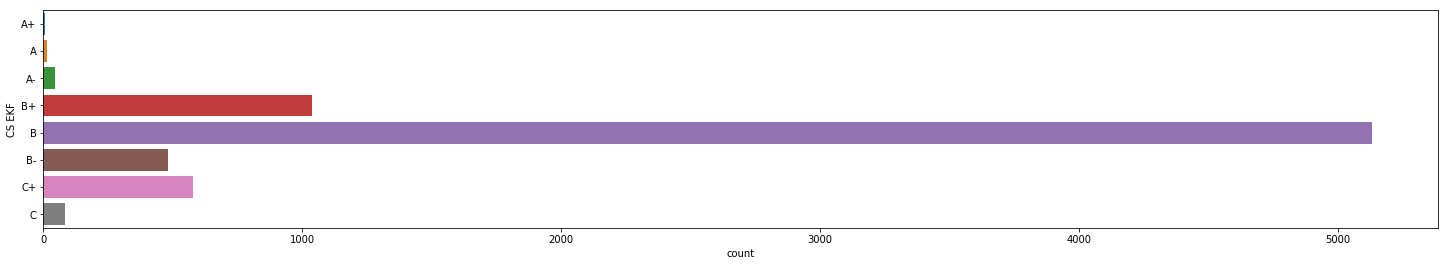

In [11]:
# Visualizing the CS EKF distribution of our dataset
fig = plt.figure(figsize=(25,4))
sns.countplot(y='CS EKF', data=data,
             order=["A+", "A", "A-", "B+", "B", "B-", "C+", "C"]) 
plt.show()

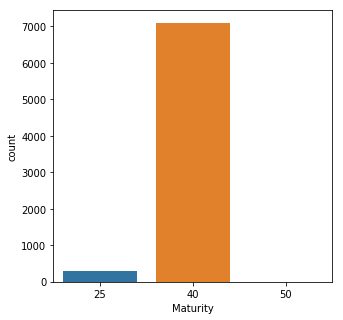

In [12]:
# Visualizing the Maturity distribution of our dataset
fig = plt.figure(figsize=(5,5))
sns.countplot(x='Maturity', data=data) 
plt.show()

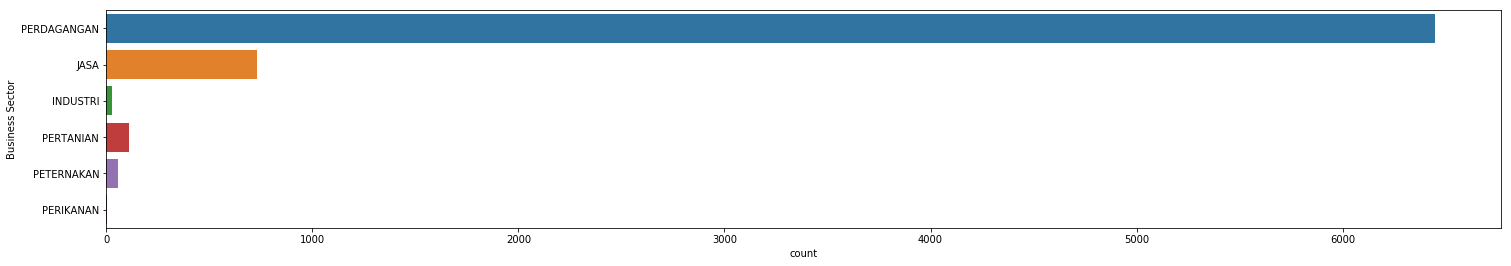

In [13]:
# Visualizing the Business Sector distribution of our dataset
fig = plt.figure(figsize=(25,4))
sns.countplot(y='Business Sector', data=data)
plt.show()

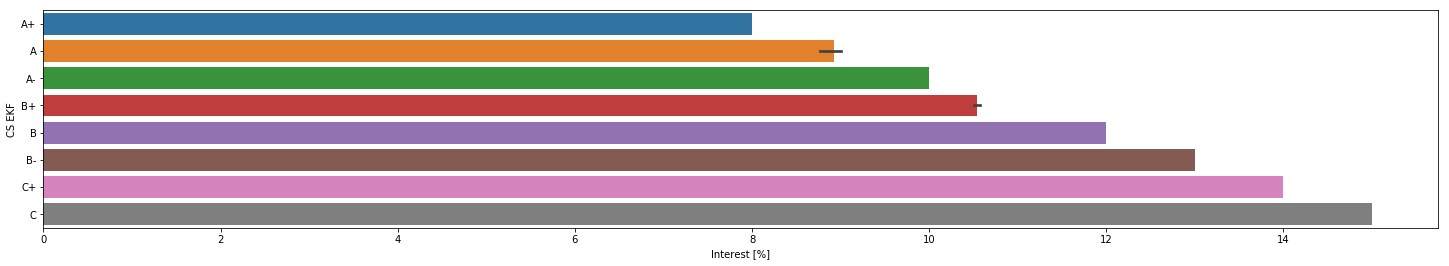

In [14]:
# Visualizing the CS EKF and Interest Rate distribution of our dataset
fig = plt.figure(figsize=(25,4))
sns.barplot(x='Interest [%]', y='CS EKF', data=data,
           order=["A+", "A", "A-", "B+", "B", "B-", "C+", "C"])

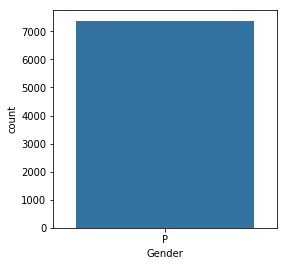

In [15]:
# Visualizing the Gender Sector distribution of our dataset
fig = plt.figure(figsize=(4,4))
sns.countplot(x='Gender', data=data) 
plt.show()

In [16]:
# Replace ' - ' value to 0 and interger
data['Length of Stay'] = data['Length of Stay'].replace({' - ':0}).astype(int)

In [17]:
## Importing Regular Expression
import re

In [18]:
# Creating formula from Years to Months (1 Year = 12 Months)
def parse_length(x):
    words = x.split()
    out = 0
    for i in range(0,len(words),2):
        if words[i+1] == 'Tahun':
            out += int(words[i])*12
        elif words[i+1] == 'Buan':
            out += int(words[i])
    return out

In [19]:
# Convert 'Years' into 'Months'
data['Length of Business Ownership'] = data['Length of Business Ownership'].apply(parse_length)

In [20]:
data.describe()

,Loan Amount,Interest [%],Maturity,Length of Business Ownership,Length of Stay
count,7.377000e+03,7377.000000,7377.000000,7377.000000,7377.000000
mean,3.813108e+06,12.029822,39.425918,75.183543,21.116307
std,6.365609e+05,0.932616,2.883864,80.365198,14.866352
min,2.300000e+06,8.000000,25.000000,1.000000,0.000000
25%,3.360000e+06,12.000000,40.000000,24.000000,8.000000
50%,3.860000e+06,12.000000,40.000000,48.000000,20.000000
75%,4.360000e+06,12.000000,40.000000,96.000000,30.000000
max,6.650000e+06,15.000000,50.000000,876.000000,110.000000


In [21]:
## Checking CS EKF value
data['CS EKF'].value_counts()

B     5133
B+    1036
C+     576
B-     482
C       85
A-      46
A       13
A+       6
Name: CS EKF, dtype: int64

In [22]:
## Data Copy & Setting up for Econding -- LabelEncoder
data_num = data.copy()

In [23]:
## Convert CS EKF value into interger data type
score_lables = {'A+': 7, 'A': 6, 'A-': 5, 'B+': 4, 'B': 3, 'B-': 2, 'C+': 1, 'C': 0}
data_num['CS EKF'] = data_num['CS EKF'].replace(score_lables).astype(int)

In [24]:
## Creating an anonymous function, transforming categorical CS EKF values into numerical values & Set Label for Encoding
data_num.loc[:, data_num.dtypes == 'object'] = data_num.loc[:, data_num.dtypes == 'object'].apply(lambda x: LabelEncoder().fit_transform(x), axis=0)

In [25]:
## Checking CS EKF score in numerical values
data_num['CS EKF'].value_counts()

3    5133
4    1036
1     576
2     482
0      85
5      46
6      13
7       6
Name: CS EKF, dtype: int64

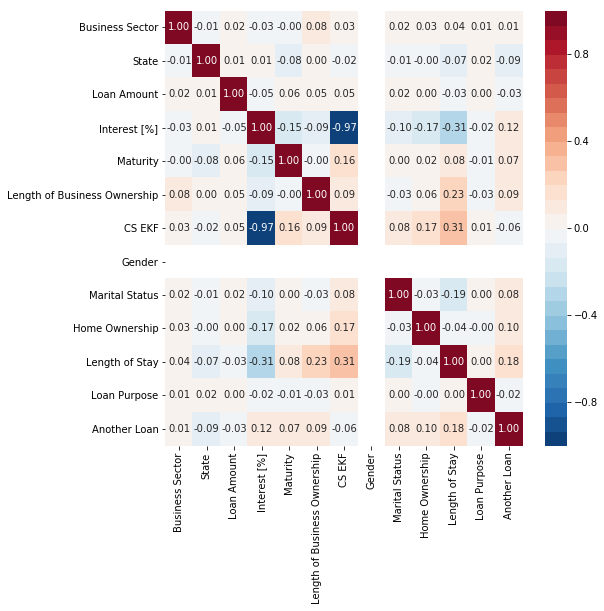

In [26]:
## Checking correlation between other variables given CS EKF as a target variable
plt.figure(figsize=(8,8))
mycorr = data_num.corr()
sns.heatmap(mycorr, vmin=-1, vmax=1, cmap=sns.color_palette("RdBu_r", 30), annot=True, fmt='.2f')

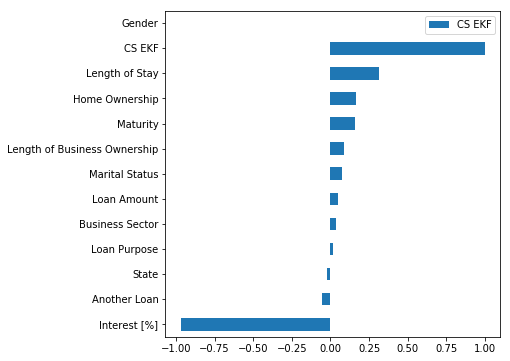

In [27]:
mycorr['CS EKF'].sort_values().to_frame().plot(kind='barh', figsize=(6,6))

### Machine Learning Algorithms

In [28]:
# Defining X and y variables for feature selection
X = data_num.drop(['CS EKF'], axis=1)
y = data_num['CS EKF']

In [29]:
y.value_counts()

3    5133
4    1036
1     576
2     482
0      85
5      46
6      13
7       6
Name: CS EKF, dtype: int64

#### KNN

In [30]:
# KNN of a 10-fold cross-validation with k=10 (the n_neighbors hyperparameter)
knn = KNeighborsClassifier(n_neighbors=10)
y_pred = cross_val_predict(knn, X, y, cv=6) #cv is the cross-validation parameter
print(classification_report(y, y_pred))
print("The average is", np.mean(y_pred == y))

              precision    recall  f1-score   support

           0       0.20      0.02      0.04        85
           1       0.55      0.22      0.32       576
           2       0.38      0.08      0.13       482
           3       0.71      0.95      0.82      5133
           4       0.28      0.05      0.09      1036
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         6

   micro avg       0.69      0.69      0.69      7377
   macro avg       0.27      0.17      0.17      7377
weighted avg       0.61      0.69      0.61      7377

The average is 0.6928290633048665


C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
knn_cm = pd.DataFrame(confusion_matrix(y, y_pred), index=score_lables.keys(), columns=score_lables.keys())
knn_cm

,A+,A,A-,B+,B,B-,C+,C
A+,2,19,5,59,0,0,0,0
A,3,127,12,431,3,0,0,0
A-,0,10,38,431,3,0,0,0
B+,5,72,43,4892,121,0,0,0
B,0,1,3,980,52,0,0,0
B-,0,0,0,42,4,0,0,0
C+,0,0,0,11,2,0,0,0
C,0,0,0,6,0,0,0,0


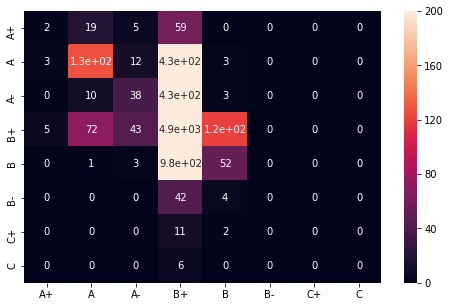

In [32]:
plt.figure(figsize=(8,5))
sns.heatmap(knn_cm, vmax=200, vmin=0, annot=True)

#### Logistic Regression

In [33]:
# Logistic Regression with a 10-fold cross validation
lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs')
lr_predictions = cross_val_predict(lr_model, X, y, cv=6)
print(classification_report(y, lr_predictions))
print("The average is", np.mean(lr_predictions == y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.00      0.00      0.00       576
           2       0.00      0.00      0.00       482
           3       0.70      1.00      0.82      5133
           4       0.00      0.00      0.00      1036
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         6

   micro avg       0.70      0.70      0.70      7377
   macro avg       0.09      0.12      0.10      7377
weighted avg       0.48      0.70      0.57      7377

The average is 0.6958113054087027


C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
lr_cm = pd.DataFrame(confusion_matrix(y, lr_predictions), index=score_lables.keys(), columns=score_lables.keys())
lr_cm

,A+,A,A-,B+,B,B-,C+,C
A+,0,0,0,85,0,0,0,0
A,0,0,0,576,0,0,0,0
A-,0,0,0,482,0,0,0,0
B+,0,0,0,5133,0,0,0,0
B,0,0,0,1036,0,0,0,0
B-,0,0,0,46,0,0,0,0
C+,0,0,0,13,0,0,0,0
C,0,0,0,6,0,0,0,0


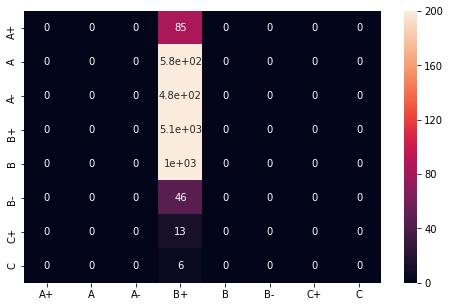

In [35]:
plt.figure(figsize=(8,5))
sns.heatmap(lr_cm, vmax=200, vmin=0, annot=True)

#### Gradient Boosting

In [36]:
# Gradient Boosting Classifier
## exponential loss, learning rate of 0.03 (ie. this shrinks the contribution of each tree by 0.03)
## 75 (number of) boosting stages to perform (GB is fairly robust to over-fitting; a large number usually results in better performance)
## Maximum depth of 6 (the maximum depth limits the number of nodes in the tree)

gb_model = GradientBoostingClassifier(learning_rate=0.03, n_estimators=75 , max_depth=6)
gb_predictions = cross_val_predict(gb_model, X, y, cv=5)
print(classification_report(y, gb_predictions))
print("The average is", np.mean(gb_predictions == y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00       576
           2       1.00      1.00      1.00       482
           3       1.00      1.00      1.00      5133
           4       0.97      0.99      0.98      1036
           5       0.46      0.26      0.33        46
           6       1.00      0.85      0.92        13
           7       0.86      1.00      0.92         6

   micro avg       0.99      0.99      0.99      7377
   macro avg       0.91      0.89      0.89      7377
weighted avg       0.99      0.99      0.99      7377

The average is 0.9933577334960011


In [37]:
gb_cm = pd.DataFrame(confusion_matrix(y, gb_predictions), index=score_lables.keys(), columns=score_lables.keys())
gb_cm

,A+,A,A-,B+,B,B-,C+,C
A+,85,0,0,0,0,0,0,0
A,0,576,0,0,0,0,0,0
A-,0,0,482,0,0,0,0,0
B+,0,0,0,5133,0,0,0,0
B,0,0,0,0,1023,13,0,0
B-,0,0,0,0,34,12,0,0
C+,0,0,0,0,0,1,11,1
C,0,0,0,0,0,0,0,6


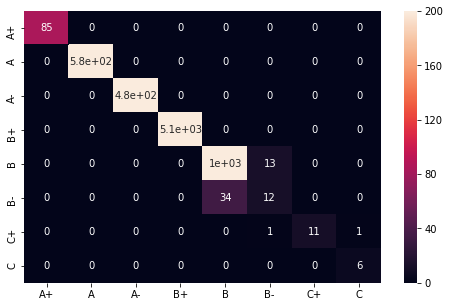

In [38]:
plt.figure(figsize=(8,5))
sns.heatmap(gb_cm, vmax=200, vmin=0, annot=True)

#### SVM

In [39]:
## Support Vector Machine - SVM seems to provide the best recall result but relatively low accuracy (compared to our other models)
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X, y, cv=5)
print(classification_report(y, svc_predictions))
print("The average is", np.mean(svc_predictions == y))

              precision    recall  f1-score   support

           0       0.67      0.02      0.05        85
           1       0.83      0.20      0.32       576
           2       0.50      0.06      0.10       482
           3       0.72      0.98      0.83      5133
           4       0.60      0.11      0.18      1036
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         6

   micro avg       0.72      0.72      0.72      7377
   macro avg       0.41      0.17      0.19      7377
weighted avg       0.69      0.72      0.64      7377

The average is 0.7169581130540871


C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
svc_cm = pd.DataFrame(confusion_matrix(y, svc_predictions), index=score_lables.keys(), columns=score_lables.keys())
svc_cm

,A+,A,A-,B+,B,B-,C+,C
A+,2,13,0,70,0,0,0,0
A,0,116,8,452,0,0,0,0
A-,1,1,27,452,1,0,0,0
B+,0,10,18,5033,72,0,0,0
B,0,0,1,924,111,0,0,0
B-,0,0,0,44,2,0,0,0
C+,0,0,0,13,0,0,0,0
C,0,0,0,6,0,0,0,0


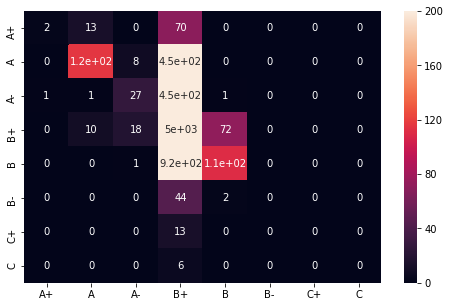

In [41]:
plt.figure(figsize=(8,5))
sns.heatmap(svc_cm, vmax=200, vmin=0, annot=True)

#### Random Forest

In [42]:
## Random Forest with Cross Validation instead of 80-20 train-test split
rf_model = RandomForestClassifier(n_estimators=100)
rf_predictions = cross_val_predict(rf_model, X, y, cv=6)
print(classification_report(y, rf_predictions))
print("The average is", np.mean(rf_predictions == y))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        85
           1       1.00      1.00      1.00       576
           2       1.00      1.00      1.00       482
           3       1.00      1.00      1.00      5133
           4       0.97      1.00      0.98      1036
           5       0.75      0.26      0.39        46
           6       0.93      1.00      0.96        13
           7       1.00      0.83      0.91         6

   micro avg       0.99      0.99      0.99      7377
   macro avg       0.96      0.88      0.90      7377
weighted avg       0.99      0.99      0.99      7377

The average is 0.9945777416293886


In [43]:
rf_cm = pd.DataFrame(confusion_matrix(y, rf_predictions), index=score_lables.keys(), columns=score_lables.keys())
rf_cm

,A+,A,A-,B+,B,B-,C+,C
A+,84,1,0,0,0,0,0,0
A,0,576,0,0,0,0,0,0
A-,0,0,482,0,0,0,0,0
B+,0,0,0,5133,0,0,0,0
B,0,0,0,0,1032,4,0,0
B-,0,0,0,0,34,12,0,0
C+,0,0,0,0,0,0,13,0
C,0,0,0,0,0,0,1,5


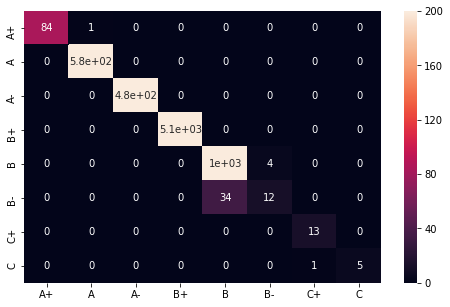

In [44]:
plt.figure(figsize=(8,5))
sns.heatmap(rf_cm, vmax=200, vmin=0, annot=True)

#### Naive Bayes

In [45]:
## Naive Bayes with Cross Validation of 10-folds
nbcv_model = GaussianNB()
nbcv_predictions = cross_val_predict(nbcv_model, X, y, cv=6)
print(classification_report(y, nbcv_predictions))
print("The average is", np.mean(nbcv_predictions == y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.00      0.00      0.00       576
           2       0.00      0.00      0.00       482
           3       0.69      0.99      0.82      5133
           4       0.00      0.00      0.00      1036
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00        13
           7       0.06      0.50      0.10         6

   micro avg       0.69      0.69      0.69      7377
   macro avg       0.09      0.19      0.11      7377
weighted avg       0.48      0.69      0.57      7377

The average is 0.6902534905788261


C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\angel\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
nb_cm = pd.DataFrame(confusion_matrix(y, nbcv_predictions), index=score_lables.keys(), columns=score_lables.keys())
nb_cm

,A+,A,A-,B+,B,B-,C+,C
A+,0,0,0,85,0,0,0,0
A,0,0,0,573,0,0,0,3
A-,0,0,0,482,0,0,0,0
B+,0,0,0,5089,0,0,0,44
B,0,0,0,1033,0,0,0,3
B-,0,0,0,46,0,0,0,0
C+,0,0,0,13,0,0,0,0
C,0,0,0,3,0,0,0,3


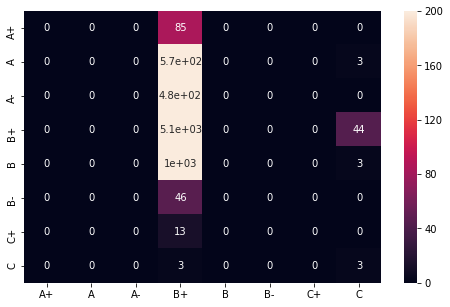

In [47]:
plt.figure(figsize=(8,5))
sns.heatmap(nb_cm, vmax=200, vmin=0, annot=True)

In [48]:
# linear: y = a1*x1 + a2*x2 + ...

#### Finding 'Maturity' Point

In [49]:
aging = pd.read_csv('AgingReport.csv')
pastdue = pd.read_csv('CategoryPastDue_30June19.csv')

In [50]:
pastdue.columns

Index(['No Contract', 'Name', 'Issue Date', 'Loan Amount', 'Maturity',
       'CS EKF', 'Sisa Pokok', 'Past Due Category', 'Business Type',
       'Bank Branch', 'Province Domicile', 'City'],
      dtype='object')

In [51]:
mydata = pd.merge(aging, pastdue, on=['No Contract', 'Loan Amount'])

In [52]:
mydata.shape

(6934, 18)

In [53]:
mydata.head()

,No Contract,No Submission of Contract,Maturity Date,Branch,Borrower Name,Lender Name,Loan Amount,Aging,Name,Issue Date,Maturity,CS EKF,Sisa Pokok,Past Due Category,Business Type,Bank Branch,Province Domicile,City
0,SPK180400044,018.0418.0003,12-11-18,PERUMNAS,TITI HIDAYATI,MELIVIA WANGKAR,"4,300,000",233,TITI HIDAYATI,04-04-18,40,B,"1,290,000",Macet,PERDAGANGAN,PERUMNAS,BANTEN,TANGERANG
1,SPK180800974,037.0818.0130,19-11-18,JATI ASIH,MARSIH SUSILAWATI,jessica fransisca wijaya,"3,300,000",226,MARSIH SUSILAWATI,23-08-18,40,B,"2,310,000",Macet,JASA,JATI ASIH,JAWA BARAT,BEKASI
2,SPK180800084,054.0818.0005,05-12-18,TOBELO,ARMA RORANO,jessica fransisca wijaya,"4,300,000",210,ARMA RORANO,03-08-18,40,B,"2,580,000",Macet,PERDAGANGAN,TOBELO,MALUKU UTARA,HALMAHERA UTARA
3,SPK180703584,046.0718.0074,11-12-18,KCP CIPONDOH,RINAWATI,jessica fransisca wijaya,"2,300,000",204,RINAWATI,26-07-18,40,B,"1,322,500",Macet,PERDAGANGAN,KCP CIPONDOH,DKI JAKARTA,JAKARTA BARAT
4,SPK180800325,042.0818.0018,11-12-18,KCP INOBONTO,YULIANA TAMALONGGEHE,jessica fransisca wijaya,"3,300,000",204,YULIANA TAMALONGGEHE,16-08-18,40,B,"2,144,000",Macet,PERDAGANGAN,KCP INOBONTO,SULAWESI UTARA,BOLAANG MONGONDOW


In [54]:
mydata.tail()

,No Contract,No Submission of Contract,Maturity Date,Branch,Borrower Name,Lender Name,Loan Amount,Aging,Name,Issue Date,Maturity,CS EKF,Sisa Pokok,Past Due Category,Business Type,Bank Branch,Province Domicile,City
6929,SPK190500935,086.0519.0284,24-07-19,KCP POMAD,NENAH SUHAENAH,KUSMIATI,"3,360,000",-,NENAH SUHAENAH,31-05-19,25,C+,"3,225,600",Lancar,PERDAGANGAN,KCP POMAD,JAWA BARAT,BOGOR
6930,SPK190500933,086.0519.0292,24-07-19,KCP POMAD,SRI WAHYUNI,KUSMIATI,"4,360,000",-,SRI WAHYUNI,31-05-19,25,C+,"4,185,600",Lancar,PERDAGANGAN,KCP POMAD,JAWA BARAT,BOGOR
6931,SPK190500926,086.0519.0286,24-07-19,KCP POMAD,NOPIANTI,Michael Hidayat Kurniaatmaja,"3,360,000",-,NOPIANTI,31-05-19,25,C,"3,225,600",Lancar,JASA,KCP POMAD,JAWA BARAT,BOGOR
6932,SPK190500931,086.0519.0293,24-07-19,KCP POMAD,NURAENI,Michael Hidayat Kurniaatmaja,"3,360,000",-,NURAENI,31-05-19,25,C+,"3,225,600",Lancar,PERDAGANGAN,KCP POMAD,JAWA BARAT,BOGOR
6933,SPK190500952,086.0519.0295,24-07-19,KCP POMAD,EVI ANDRIYANTI,Suryana CH Jamhur,"3,360,000",-,EVI ANDRIYANTI,31-05-19,25,C+,"3,225,600",Lancar,PERDAGANGAN,KCP POMAD,JAWA BARAT,BOGOR


In [55]:
mydata.isnull().sum()

No Contract                  0
No Submission of Contract    0
Maturity Date                0
Branch                       0
Borrower Name                0
Lender Name                  0
Loan Amount                  0
Aging                        0
Name                         0
Issue Date                   0
Maturity                     0
CS EKF                       0
Sisa Pokok                   0
Past Due Category            0
Business Type                0
Bank Branch                  0
Province Domicile            0
City                         0
dtype: int64

In [56]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6934 entries, 0 to 6933
Data columns (total 18 columns):
No Contract                  6934 non-null object
No Submission of Contract    6934 non-null object
Maturity Date                6934 non-null object
Branch                       6934 non-null object
Borrower Name                6934 non-null object
Lender Name                  6934 non-null object
Loan Amount                  6934 non-null object
Aging                        6934 non-null object
Name                         6934 non-null object
Issue Date                   6934 non-null object
Maturity                     6934 non-null int64
CS EKF                       6934 non-null object
Sisa Pokok                   6934 non-null object
Past Due Category            6934 non-null object
Business Type                6934 non-null object
Bank Branch                  6934 non-null object
Province Domicile            6934 non-null object
City                         6934 non-null o

In [57]:
mydata.drop(['No Contract', 'Lender Name', 'Borrower Name', 'Name', 'No Submission of Contract', 
           'Issue Date', 'Maturity Date', 'Bank Branch'], axis=1, inplace=True)

In [58]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6934 entries, 0 to 6933
Data columns (total 10 columns):
Branch               6934 non-null object
Loan Amount          6934 non-null object
Aging                6934 non-null object
Maturity             6934 non-null int64
CS EKF               6934 non-null object
Sisa Pokok           6934 non-null object
Past Due Category    6934 non-null object
Business Type        6934 non-null object
Province Domicile    6934 non-null object
City                 6934 non-null object
dtypes: int64(1), object(9)
memory usage: 595.9+ KB


In [59]:
mydata['Loan Amount'] = mydata['Loan Amount'].str.replace(',', '').astype(int)

In [60]:
mydata['Aging'] = mydata['Aging'].replace({' - ': 0}).astype(int)

In [61]:
mydata[['Aging', 'Maturity', 'Loan Amount']].corr()

,Aging,Maturity,Loan Amount
Aging,1.000000,0.025059,-0.119765
Maturity,0.025059,1.000000,0.040588
Loan Amount,-0.119765,0.040588,1.000000


In [62]:
mydata['Province Domicile'].value_counts()

JAWA BARAT           4076
SULAWESI SELATAN     1068
BANTEN                602
GORONTALO             549
SULAWESI UTARA        316
DKI JAKARTA           278
SULAWESI TENGGARA      36
MALUKU UTARA            9
Name: Province Domicile, dtype: int64

In [63]:
mydata_num = mydata.copy()

In [64]:
## Convert CS EKF value into interger data type
province_labels = {'JAWA BARAT': 1, 'SULAWESI SELATAN': 2, 'BANTEN': 3, 'GORONTALO': 4, 'SULAWESI UTARA': 5, 'DKI JAKARTA': 6, 'SULAWESI TENGGARA': 7, 'MALUKU UTARA': 8}
mydata_num['Province Domicile'] = mydata['Province Domicile'].replace(province_labels).astype(int)

In [65]:
mydata_num['Province Domicile'].value_counts()

1    4076
2    1068
3     602
4     549
5     316
6     278
7      36
8       9
Name: Province Domicile, dtype: int64

In [66]:
mydata_num.loc[:, mydata_num.dtypes == 'object'] = mydata_num.loc[:, mydata_num.dtypes == 'object'].apply(lambda x: LabelEncoder().fit_transform(x), axis=0)

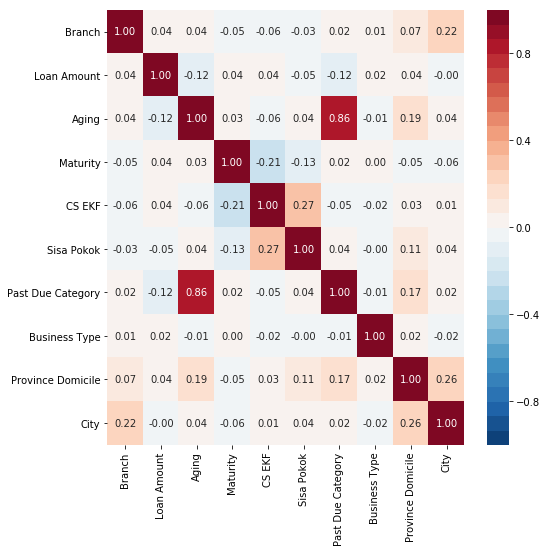

In [67]:
plt.figure(figsize=(8,8))
mydatacorr = mydata_num.corr()
sns.heatmap(mydatacorr, vmin=-1, vmax=1, cmap=sns.color_palette("RdBu_r", 30), annot=True, fmt='.2f')

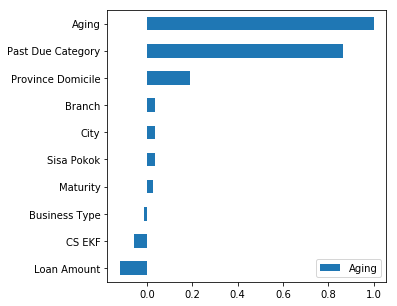

In [68]:
mydatacorr['Aging'].sort_values().to_frame().plot(kind='barh', figsize=(5,5))

In [69]:
mydata['Past Due Category'].value_counts()

Lancar           6803
Macet             113
Kurang Lancar      12
Tidak Lancar        6
Name: Past Due Category, dtype: int64

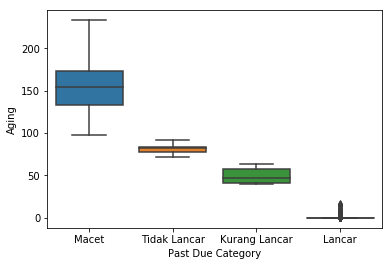

In [70]:
sns.boxplot(x='Past Due Category', y='Aging', data=mydata)

In [71]:
mydata.groupby('Past Due Category')['Aging'].describe()

,count,mean,std,min,25%,50%,75%,max
Past Due Category,,,,,,,,
Kurang Lancar,12.0,49.500000,9.337120,40.0,41.00,46.5,57.25,64.0
Lancar,6803.0,0.122299,0.763610,0.0,0.00,0.0,0.00,16.0
Macet,113.0,152.893805,27.539051,98.0,133.00,154.0,173.00,233.0
Tidak Lancar,6.0,81.666667,6.947422,72.0,77.75,83.0,83.75,92.0


In [72]:
y.value_counts(normalize=True)

3    0.695811
4    0.140436
1    0.078081
2    0.065338
0    0.011522
5    0.006236
6    0.001762
7    0.000813
Name: CS EKF, dtype: float64

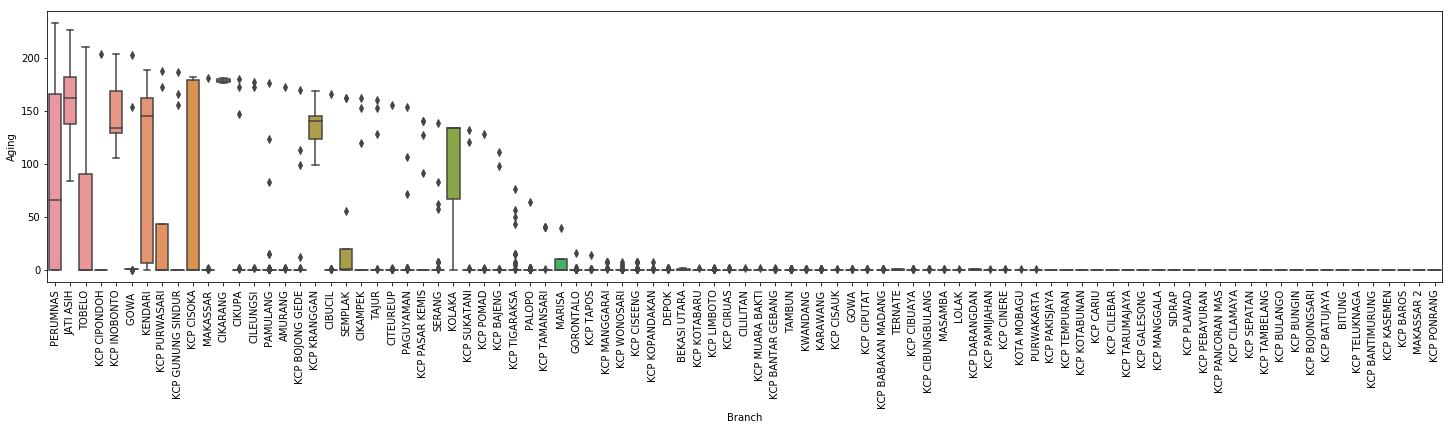

In [73]:
plt.figure(figsize=(25,5))
sns.boxplot(x='Branch', y='Aging', data=mydata)
plt.xticks(rotation=90);

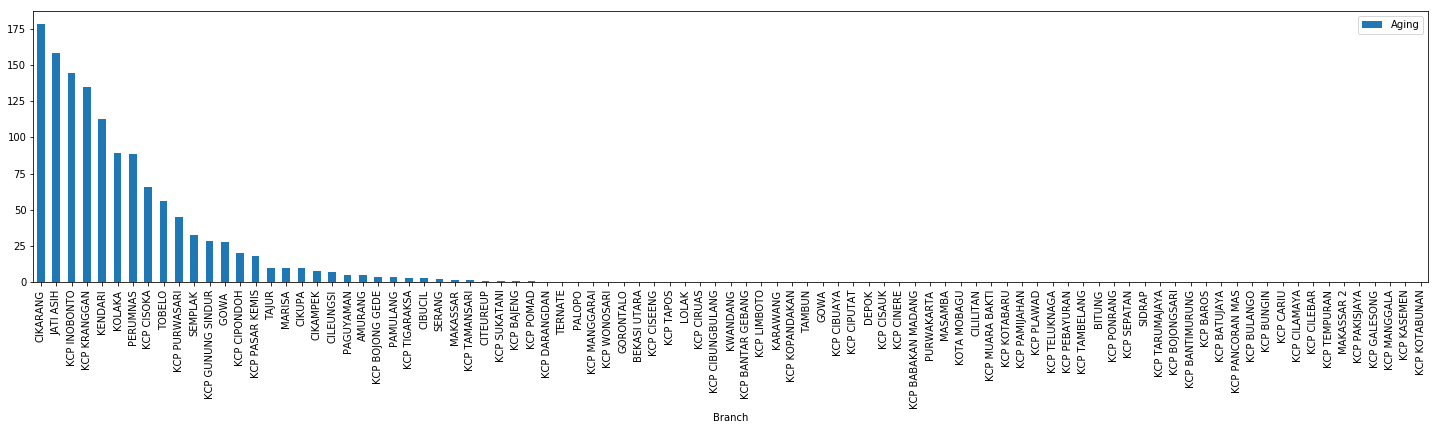

In [74]:
mydata.groupby('Branch')['Aging'].mean().sort_values(ascending=False).to_frame().plot(kind='bar', figsize=(25,5))
plt.xticks(rotation=90);